# Training a RL Agent with Stable-Baselines3 Using a GEM Environment

This notebook serves as an educational introduction to the usage of Stable-Baselines3 using a gym-electric-motor (GEM) environment. The goal of this notebook is to give an understanding of what Stable-Baselines3 is and how to use it to train and evaluate a reinforcement learning agent that can solve a current control problem of the GEM toolbox.

## 1. Installation

Before you can start you need to make sure that you have both gym-electric-motor and Stable-Baselines3 installed. You can install both easily using pip:

- ```pip install gym-electric-motor```
- ```pip install stable-baselines3```

Alternatively, you can install them and their latest developer version directly from GitHub:

- https://github.com/upb-lea/gym-electric-motor
- https://github.com/DLR-RM/stable-baselines3

For this notebook, the following cell will do the job:

## 2. Setting up a GEM Environment

The basic idea behind reinforcement learning is to create a so-called agent, that should learn by itself to solve a specified task in a given environment. 
This environment gives the agent feedback on its actions and reinforces the targeted behavior.
In this notebook, the task is to train a controller for the current control of a *permanent magnet synchronous motor* (*PMSM*).
 
In the following, the used GEM-environment is briefly presented, but this notebook does not focus directly on the detailed usage of GEM. If you are new to the used environment and interested in finding out what it does and how to use it, you should take a look at the [GEM cookbook](https://colab.research.google.com/github/upb-lea/gym-electric-motor/blob/master/examples/example_notebooks/GEM_cookbook.ipynb).

The basic idea of the control setup from the GEM-environment is displayed in the following figure. 

![](../../docs/plots/SCML_Overview.png)

The agent controls the converter who converts the supply currents to the currents flowing into the motor - for the *PMSM*: $i_{sq}$ and $i_{sd}$

In the continuous case, the agent's action equals a duty cycle which will be modulated into a corresponding voltage. 

In the discrete case, the agent's actions denote switching states of the converter at the given instant. Here, only a discrete amount of options are available. In this notebook, for the PMSM the *discrete B6 bridge converter* with six switches is utilized per default. This converter provides a total of eight possible actions.

![](../../docs/plots/B6.svg)

The motor schematic is the following:


![](../../docs/plots/ESBdq.svg)

And the electrical ODEs for that motor are:

<h3 align="center">

<!-- $\frac{\mathrm{d}i_{sq}}{\mathrm{d}t} = \frac{u_{sq}-pL_d\omega_{me}i_{sd}-R_si_{sq}}{L_q}$

$\frac{\mathrm{d}i_{sd}}{\mathrm{d}t} = \frac{u_{sd}-pL_q\omega_{me}i_{sq}-R_si_{sd}}{L_d}$

$\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$
 -->

   $ \frac{\mathrm{d}i_{sd}}{\mathrm{d}t}=\frac{u_{sd} + p\omega_{me}L_q i_{sq} - R_s i_{sd}}{L_d} $ <br><br>
    $\frac{\mathrm{d} i_{sq}}{\mathrm{d} t}=\frac{u_{sq} - p \omega_{me} (L_d i_{sd} + \mathit{\Psi}_p) - R_s i_{sq}}{L_q}$ <br><br>
   $\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$

</h3>

The target for the agent is now to learn to control the currents. For this, a reference generator produces a trajectory that the agent has to follow. 
Therefore, it has to learn a function (policy) from given states, references and rewards to appropriate actions.

For a deeper understanding of the used models behind the environment see the [documentation](https://upb-lea.github.io/gym-electric-motor/).
Comprehensive learning material to RL is also [freely available](https://github.com/upb-lea/reinforcement_learning_course_materials).

In [2]:
import time
from typing import Tuple, Optional, List, Type

import gymnasium as gym
import numpy as np
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt

from gymnasium import ObservationWrapper
from gymnasium.wrappers import TimeLimit
from gymnasium.spaces import Box

from stable_baselines3 import DDPG, TD3
from stable_baselines3.common.policies import BaseModel
from stable_baselines3.common.preprocessing import get_action_dim
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.utils import update_learning_rate
from stable_baselines3.td3.policies import Actor, TD3Policy

from gym_electric_motor import gym_electric_motor as gem
from gym_electric_motor.physical_systems.mechanical_loads import ConstantSpeedLoad
from gym_electric_motor.physical_system_wrappers import CosSinProcessor, DeadTimeProcessor, DqToAbcActionProcessor
from gym_electric_motor.envs.motors import ActionType, ControlType, Motor, MotorType
from gym_electric_motor.physical_systems.solvers import EulerSolver


In [3]:
class FeatureWrapper(ObservationWrapper):
    """
    Wrapper class which wraps the environment to change its observation from a tuple to a flat vector.
    """

    def __init__(self, env):
        """
        Changes the observation space from a tuple to a flat vector
        
        Args:
            env(GEM env): GEM environment to wrap
        """
        super(FeatureWrapper, self).__init__(env)
        state_space = self.env.observation_space[0]
        ref_space = self.env.observation_space[1]
        
        new_low = np.concatenate((state_space.low,
                                  ref_space.low))
        new_high = np.concatenate((state_space.high,
                                   ref_space.high))

        self.observation_space = Box(new_low, new_high)

    def observation(self, observation):
        """
        Gets called at each return of an observation.
        
        """
        observation = np.concatenate((observation[0],
                                      observation[1],
                                      ))
        return observation
    
class LastActionWrapper(gym.Wrapper):
    def __init__(self, env):
        super(LastActionWrapper, self).__init__(env)
        state_space = self.env.observation_space
        action_space = self.env.action_space
        
        new_low = np.concatenate((state_space.low,
                                  action_space.low))
        new_high = np.concatenate((state_space.high,
                                   action_space.high))

        self.observation_space = Box(new_low, new_high)

    def reset(self, **kwargs):
        observation, info = self.env.reset(**kwargs)
        self.last_action = np.zeros(self.action_space.shape[0], dtype=np.float32)
        return np.concatenate((observation, self.last_action)), info

    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)
        self.last_action = action
        return np.concatenate((observation, self.last_action)), reward, terminated, truncated, info


In [6]:
# Define the environment type
motor = Motor(MotorType.PermanentMagnetSynchronousMotor,
              ControlType.CurrentControl,
              ActionType.Continuous)
tau = 1e-4    # The duration of each sampling step

# motor type: Brusa HSM16.17.12-C01
motor_parameter = dict(
    p=3,                # [p] = 1, nb of pole pairs
    r_s=17.932e-3,      # [r_s] = Ohm, stator resistance
    l_d=0.37e-3,        # [l_d] = H, d-axis inductance
    l_q=1.2e-3,         # [l_q] = H, q-axis inductance
    psi_p=65.65e-3,     # [psi_p] = Vs, magnetic flux of the permanent magnet
)  

nominal_values=dict(
    omega=6000*2*np.pi/60,  # angular velocity in rpm
    i=240,                  # motor current in amps
    u=350,                  # nominal voltage in volts
)

limit_values = dict(
    omega = 6000*2*np.pi/60,
    i = 240*1.2,
    u = 350,
)

pmsm_init = {
    'states': {
        'i_sd': 0.,
        'i_sq': 0.,
        'epsilon': 0.,
                }
}

physical_system_wrappers = [
    # Wrapped directly around the physical system
    CosSinProcessor(angle='epsilon'),
    DqToAbcActionProcessor.make('PMSM'),
    DeadTimeProcessor(steps=1) # Only use DeadTimeWrapper after you have implemented a last action concatinator for the state
    # Wrapped around the CosSinProcessor. Therefore, the generated states (cos and sin) can be accessed.
]

# define the random initialisation for load and motor
load_init = {'states': {'omega': 4000*2*np.pi/60 * 0.2}}
#load_init={'random_init': 'uniform', }
load = ConstantSpeedLoad(
    omega_fixed=4000*2*np.pi/60 * 0.2 #load_init 
)

env = gem.make(  
    motor.env_id(),    
    # parameterize the PMSM and update limitations
    motor=dict(
        motor_parameter=motor_parameter,
        limit_values=limit_values,
        nominal_values=nominal_values,
        motor_initializer=pmsm_init,
    ),   
    load=load,
    tau=tau,
    ode_solver=EulerSolver(),#'euler',
    physical_system_wrappers=physical_system_wrappers, # Pass the Physical System Wrappers
    state_filter=[ "i_sd", "i_sq","omega","epsilon", "sin(epsilon)", "cos(epsilon)"],
    supply=dict(u_nominal=350),   
)

eps_idx = env.unwrapped.physical_system.state_names.index('epsilon')
i_sd_idx = env.unwrapped.physical_system.state_names.index('i_sd')
i_sq_idx = env.unwrapped.physical_system.state_names.index('i_sq')

env= TimeLimit(LastActionWrapper(FeatureWrapper(env)), max_episode_steps=200)

print(env.action_space.sample())

[-0.93812867 -0.91050376]


/home/leppy/.pyenv/versions/motor-rl/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/leppy/.pyenv/versions/motor-rl/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## 3. Training an Agent with Stable-Baselines3

Stable-Baselines3 collects Reinforcement Learning algorithms implemented in Pytorch. 

Stable-Baselines3 is still a very new library with its current release being 0.9. That is why its collection of algorithms is not very large yet and most algorithms lack more advanced variants. However, its authors planned to broaden the available algorithms in the future. For currently available algorithms see their [documentation](https://stable-baselines3.readthedocs.io/en/master/guide/rl.html).

To use an agent provided by Stable-Baselines3 your environment has to have a [gym interface](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html). 

### 3.1 Imports

The environment in this control problem poses a continuous action space. Therefore, the [Deep Deterministic Policy Gradient (DDPG)](https://arxiv.org/abs/1509.02971) is a suitable agent.
For the specific implementation of the DDPG you can refer to [Stable-Baslines3's docs](https://stable-baselines3.readthedocs.io/en/master/modules/ddpg.html).

In this tutorial two customized multi-layer perceptron (MLP) are used as critic and actor. This allows different learning rates for actor and critic

In [7]:
class CustomDDPG(DDPG):
    def __init__(self, policy, env, *args, actor_lr=1e-5, critic_lr=1e-4, **kwargs):
    #def __init__(self, policy, env, *args, actor_lr=1e-5, critic_lr=1e-4, **kwargs):
        super().__init__(policy, env, *args, **kwargs)
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr

    def _update_learning_rate(self, optimizers):
        """
                Costum function to update actor and critic with different learning rates.
                Based on https://github.com/DLR-RM/stable-baselines3/issues/338
                """
        actor_optimizer, critic_optimizer = optimizers

        update_learning_rate(actor_optimizer, self.actor_lr)
        update_learning_rate(critic_optimizer, self.critic_lr)

In [8]:
def create_network(input_dim, hidden_sizes, output_dim, activations):
    """
    Create a neural network with customizable layers, sizes, and activation functions.

    Args:
    - input_dim (int): The size of the input layer.
    - hidden_sizes (list): List of integers representing the sizes of each hidden layer.
    - output_dim (int): The size of the output layer.
    - activations (list): List of tuples where each tuple contains the activation function
                          name as the first element and any parameters as subsequent elements.
                          Pass None for layers without activation.

    Returns:
    - network (nn.Sequential): The created neural network.
    """

    layers = []
    
    # Input layer
    layers.append(nn.Linear(input_dim, hidden_sizes[0]))
    
    # Activation function for the first hidden layer
    if activations[0] is not None:
        activation, *params = activations[0]
        act_func = getattr(nn, activation)(*params)
        layers.append(act_func)

    # Hidden layers
    for i in range(1, len(hidden_sizes)):
        layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))

        # Activation function
        if activations[i] is not None:
            activation, *params = activations[i]
            act_func = getattr(nn, activation)(*params)
            layers.append(act_func)

    # Output layer
    layers.append(nn.Linear(hidden_sizes[-1], output_dim))

    # Activation function for output layer
    if activations[-1] is not None:
        activation, *params = activations[-1]
        act_func = getattr(nn, activation)(*params)
        layers.append(act_func)

    return nn.Sequential(*layers)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

actor_activations = [('ReLU',), ('LeakyReLU', 0.2), ('Tanh',)]
critic_activations = [('ReLU',), ('LeakyReLU', 0.1), None]

actor_network = create_network(
    input_dim = state_dim,
    output_dim = action_dim,
    hidden_sizes =[100, 100],
    activations=actor_activations)

critic_network = create_network(
    input_dim=state_dim + action_dim,
    output_dim=1,
    hidden_sizes= [100, 100],
    activations=critic_activations)


In [9]:
class CustomActor(Actor):
    """
    Actor network (policy) for TD3.
    """
    def __init__(self, *args, **kwargs):
        super(CustomActor, self).__init__(*args, **kwargs)
        # Define custom network with Dropout
        # WARNING: it must end with a tanh activation to squash the output
        #self.mu = nn.Sequential(...)
        self.mu = actor_network

class CustomContinuousCritic(BaseModel):
    """
    Critic network(s) for DDPG/SAC/TD3.
    """
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        net_arch: List[int],
        features_extractor: nn.Module,
        features_dim: int,
        activation_fn: Type[nn.Module] = nn.ReLU,
        normalize_images: bool = True,
        n_critics: int = 2,
        share_features_extractor: bool = True,
    ):
        super().__init__(
            observation_space,
            action_space,
            features_extractor=features_extractor,
            normalize_images=normalize_images,
        )

        action_dim = get_action_dim(self.action_space)

        self.share_features_extractor = share_features_extractor
        self.n_critics = n_critics
        self.q_networks = []
        for idx in range(n_critics):
            # Define critic with Dropout here
            q_net = critic_network
            self.add_module(f"qf{idx}", q_net)
            self.q_networks.append(q_net)

    def forward(self, obs: th.Tensor, actions: th.Tensor) -> Tuple[th.Tensor, ...]:
        # Learn the features extractor using the policy loss only
        # when the features_extractor is shared with the actor
        with th.set_grad_enabled(not self.share_features_extractor):
            features = self.extract_features(obs, self.features_extractor)
        qvalue_input = th.cat([features, actions], dim=1)
        return tuple(q_net(qvalue_input) for q_net in self.q_networks)

    def q1_forward(self, obs: th.Tensor, actions: th.Tensor) -> th.Tensor:
        """
        Only predict the Q-value using the first network.
        This allows to reduce computation when all the estimates are not needed
        (e.g. when updating the policy in TD3).
        """
        with th.no_grad():
            features = self.extract_features(obs, self.features_extractor)
        return self.q_networks[0](th.cat([features, actions], dim=1))

class CustomTD3Policy(TD3Policy):
    def __init__(self, *args, **kwargs):

        
        super(CustomTD3Policy, self).__init__(*args, **kwargs)


    def make_actor(self, features_extractor: Optional[BaseFeaturesExtractor] = None) -> CustomActor:
        actor_kwargs = self._update_features_extractor(self.actor_kwargs, features_extractor)
        return CustomActor(**actor_kwargs).to(self.device)

    def make_critic(self, features_extractor: Optional[BaseFeaturesExtractor] = None) -> CustomContinuousCritic:
        critic_kwargs = self._update_features_extractor(self.critic_kwargs, features_extractor)
        return CustomContinuousCritic(**critic_kwargs).to(self.device)

TD3.policy_aliases["CustomTD3Policy"] = CustomTD3Policy

### 3.2 Parameterization

For the DDPG algorithm you have to define a set of parameters.

In [10]:
nb_steps = 256000 # number of training steps
buffer_size = nb_steps #number of old observation steps saved
learning_starts = 32 # memory warmup
train_freq = 1 # prediction network gets an update each train_freq's step
batch_size = 32 # mini batch size drawn at each update step
gamma = 0.85
verbose = 1 # verbosity of stable-basline's prints
lr_actor = 1e-4
lr_critic = 1e-3

Additionally, you have to define how long your agent shall train. You can just set a concrete number of steps or use knowledge of the environment's temporal resolution to define an in-simulation training time. In this example, the agent is trained for five seconds which translates in this environment's case to 500000 steps.

### 3.3 Training of the Agent

Once you've setup the environment and defined your parameters starting the training is nothing more than a one-liner. For each algorithm all you have to do is call its ```learn()``` function. However, you should note that the execution of the training can take a long time. Currently, Stable-Baselines3 does not provide any means of saving the training reward for later visualization. Therefore, a ```RewardLogger``` callback is used for this environment (see code a few cells above).

In [11]:
policy_kwargs = dict(optimizer_class=th.optim.Adam,)

agent = CustomDDPG("CustomTD3Policy", env, buffer_size=buffer_size, learning_starts=learning_starts ,train_freq=train_freq, 
            batch_size=batch_size, gamma=gamma, policy_kwargs=policy_kwargs, 
            verbose=verbose, actor_lr=lr_actor, critic_lr=lr_critic)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [12]:

start_time = time.time()
agent.learn(total_timesteps=nb_steps)
total_time = time.time() - start_time
print(f"Batch size 1 total time: {total_time // 60} minutes, {total_time % 60} seconds")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | -36.9    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 154      |
|    time_elapsed    | 2        |
|    total_timesteps | 432      |
| train/             |          |
|    actor_loss      | 1.56     |
|    critic_loss     | 0.00599  |
|    n_updates       | 399      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 68.4     |
|    ep_rew_mean     | -26.4    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 153      |
|    time_elapsed    | 3        |
|    total_timesteps | 547      |
| train/             |          |
|    actor_loss      | 2.15     |
|    critic_loss     | 1.46     |
|    n_updates       | 514      |
---------------------------------
---------------------------------
| rollout/    

KeyboardInterrupt: 

In [13]:
obs, _ = env.reset()

# Take trained agent and loop over environment
i_ds = []
i_qs = []
i_ds_ref = []
i_qs_ref = []
omegas = []
i_sd_idx = 0
i_sq_idx = 1
i_sd_ref_idx = -4
i_sq_ref_idx = -3
omega_idx = 2
for i in range(1000):
    action, _states = agent.predict(obs, deterministic=True)
    obs, rewards, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    i_ds.append(obs[i_sd_idx])
    i_qs.append(obs[i_sq_idx])
    i_ds_ref.append(obs[i_sd_ref_idx])
    i_qs_ref.append(obs[i_sq_ref_idx])
    omegas.append(obs[omega_idx])
    if done:
        obs,_ = env.reset()

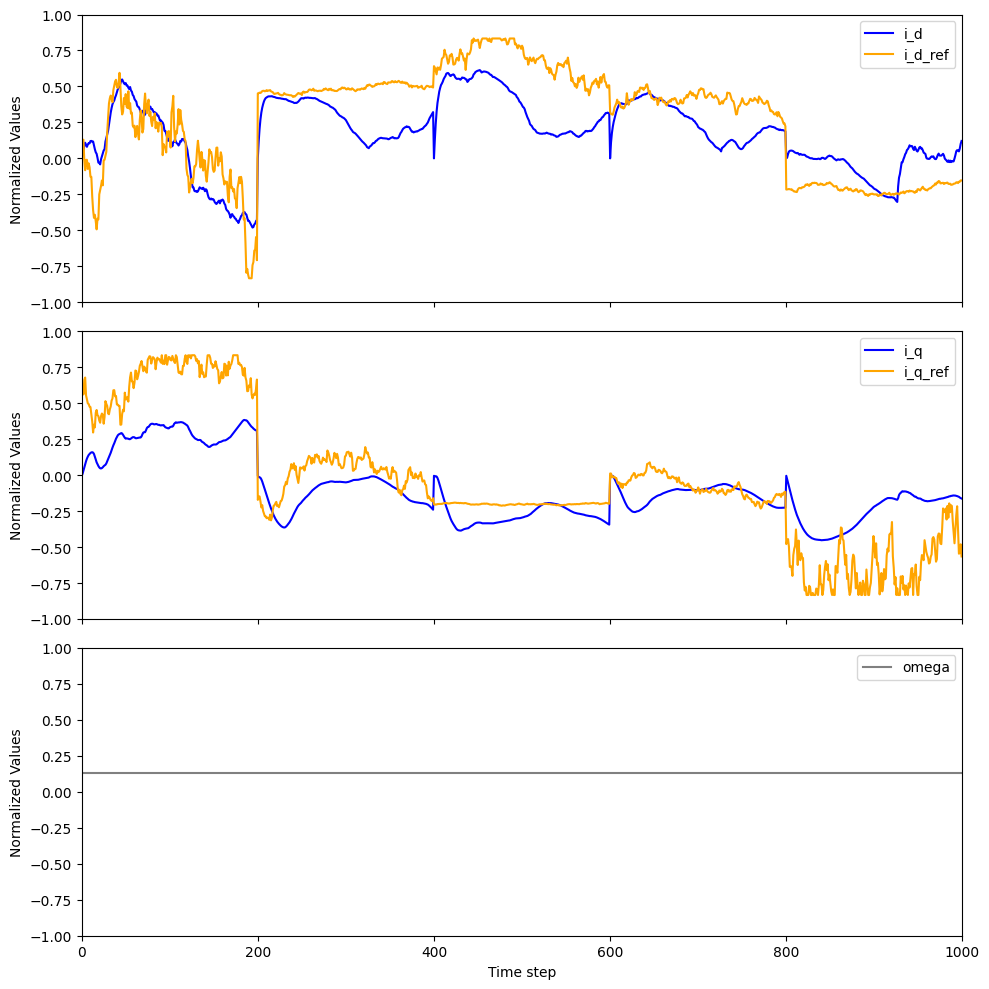

In [14]:
time_points = range(len(i_ds))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# First subplot for i_ds and i_ds_ref
ax1.plot(time_points, i_ds, label='i_d', color='blue')
ax1.plot(time_points, i_ds_ref, label='i_d_ref', color='orange')
ax1.set_ylabel('Normalized Values')
ax1.legend()
ax1.set_ylim([-1, 1])

# Second subplot for i_qs and i_qs_ref
ax2.plot(time_points, i_qs, label='i_q', color='blue')
ax2.plot(time_points, i_qs_ref, label='i_q_ref', color='orange')
ax2.set_ylabel('Normalized Values')
ax2.legend()
ax2.set_ylim([-1, 1])

ax3.plot(time_points, omegas, label='omega', color='grey')
ax3.set_xlabel('Time step')
ax3.set_ylabel('Normalized Values')
ax3.legend()
ax3.set_ylim([-1,1])
ax3.set_xlim([0, 1000])
# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()